# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [15]:
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu, threshold_minimum, threshold_local
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.morphology import binary_closing, binary_opening
from skimage.color import label2rgb

#### Extract data .tar

In [4]:
import tarfile
import os

# extract the .tar.gz archive
data_folder = 'data'
data_filename = 'project-data'
tar_path = os.path.join(data_folder, data_filename + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_folder)

#### Main folder paths

In [5]:
train_path = os.path.join(data_folder, data_filename, 'images', 'train')
train_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'train')

test_path = os.path.join(data_folder, data_filename, 'images', 'test')
test_annotations_path = os.path.join(data_folder, data_filename, 'annotations', 'test')

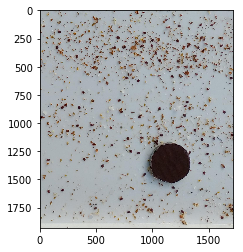

In [6]:
# Display an image
train_path = os.path.join(data_folder, data_filename, 'images', 'train')
varroa_01 = skimage.io.imread(os.path.join(train_path, '5a1e4c82a07d5643ecfab296_32.00px_5.jpg'))
plt.imshow(varroa_01)

#### Detect by segmentation method

In the following code, I will adopt the following box format:

\begin{equation}
[x_{center}, y_{center}, h, w]
\end{equation}

using Python table indexing, i.e.:
- x = ↓ (height)
- y = → (width)

Knowing that boxes annotations follows the scheme:

\begin{equation}
[minc, minr, w, h]
\end{equation}

it is translated into my notation as follow:

\begin{equation}
[y_{min}, x_{min}, w, h]
\end{equation}

Note: image processing indexing follows the rule:
- x = → 
- y = ↓ 

If using this convention, tranlaste it in Pyhton as (y, x)

In [61]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    image = skimage.color.rgb2grey(img)
    
    # before applying 'otsu', we need to assess whether there is more than one color in the img (necessary cond)
    unique, counts = np.unique(img, return_counts=True)
    color_dict = dict(zip(unique, counts))
    
    if len(color_dict) > 1:
        thresh = threshold_otsu(image)
        image = binary_closing(image < thresh, disk(1)) #closing(image < thresh)

        image = clear_border(image)

        label_image = label(image)

        varroa_pred = []
        for region in regionprops(label_image):
            if (region.area >= 150 and region.area <= 750): #250 - 750
                # get coordinates of the varoa:
                # centroid coordinate tuple: (row, col)
                x_center, y_center = region.centroid
                # get bounding box properties
                minr, minc, maxr, maxc = region.bbox

                # condition to remove 'unshaped' objects
                #if (maxc-minc)/(maxr - minr) > 0.6 and (maxc - minc)/(maxr - minr) < 1.7:
                varroa_pred.append([x_center, y_center, maxr-minr, maxc-minc])

    else:
        varroa_pred = [0, 0, 0, 0]
    
    return varroa_pred

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

#### Useful methods

In [7]:
# Key: to compute these values we need the ground truth
# Ground truth obtained by reading xml file > c.f. function given lab 1

# read annotations
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [8]:
# Function to compute the intersection, union and iou

def area(box):
    return box[2]*box[3]

def overlap_area(box1, box2):
    '''
    reminder box structure: [x_center, y_center, h, w]
    convention: x = ↓ (height) and y = → (width)
    hence: 
        - h = maxr-minr = x_max-x_min
        - w = maxc-minc = y_max-y_min 
    '''
    x_center_1 = box1[0]
    y_center_1 = box1[1]
    h1 = box1[2]
    w1 = box1[3]
    x_min_1 = x_center_1-(h1/2)
    x_max_1 = x_center_1+(h1/2)
    y_min_1 = y_center_1-(w1/2)
    y_max_1 = y_center_1+(w1/2)
        
    x_center_2 = box2[0]
    y_center_2 = box2[1]
    h2 = box2[2]
    w2 = box2[3]
    x_min_2 = x_center_2-(h2/2)
    x_max_2 = x_center_2+(h2/2)
    y_min_2 = y_center_2-(w2/2)
    y_max_2 = y_center_2+(w2/2)
    
    dx = min(x_max_1, x_max_2) - max(x_min_1, x_min_2)
    dy = min(y_max_1, y_max_2) - max(y_min_1, y_min_2)
    
    if (dx >= 0) and (dy >= 0):
        return dx*dy
    else: 
        return 0
    
def union_area(box1, box2):
    return (area(box1) + area(box2) - overlap_area(box1, box2))
    
def IoU(box1, box2):
    return (overlap_area(box1, box2) / overlap_area(box1, box2))

In [9]:
# Test
print(overlap_area([1,1,2,2], [2,2,2,2]))
print(overlap_area([1,1,2,2], [5,5,2,2]))

1.0
0


In [34]:
def compute_statistics(varroa_ground_truth, varroa_pred, threshold=0.3):
    ious = []
    tp = 0
    fn = 0
    fp = 0
    for i in varroa_ground_truth:
        iou_tmp = 0
        for j in varroa_pred:
            if (overlap_area(i, j) != 0):
                if IoU(i, j) > iou_tmp:
                    iou_tmp = IoU(i, j)

        if iou_tmp > threshold:
            tp +=1
        else:
            fn += 1

    for i in varroa_pred:
        iou_tmp = 0
        for j in varroa_ground_truth:
            if (overlap_area(i, j) != 0):
                if IoU(i,j) > iou_tmp:
                    iou_tmp = IoU(i, j)

        if iou_tmp < threshold:
            fp +=1
    if ((tp + fp) != 0):
        precision = tp / (tp + fp)
    else:
        precision = 0
    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = 0
    if (precision + recall) != 0: 
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
    
    return precision, recall, f1

#### Pipeline

Here, I will extract the name of the img together with the associated annotations.

In [35]:
# Get names without extension
list_dir = os.listdir(test_annotations_path) #or test_path
names = []

for name in list_dir:
    n = os.path.splitext(name)[0]
    names.append(n)

names[0]

'59ef06a3a07d563535ffc6c9_32.00px_13'

In [38]:
threshold = 0.3

# test with on singla img
#names = ['58e7db24579e520d2470641c_32.00px_4']

for name in names:
    img_name = os.path.join(test_path, name + '.jpg')
    img = skimage.io.imread(img_name)
    annotation = os.path.join(test_annotations_path, name + '.xml')
    
    # get the prediction boxes of the image 
    varroa_pred = detect_by_segmentation(img)
    
    # get the ground truth boxes
    annotations_xml = parse_file(annotation)

    varroa_ground_truth = []
    for anno in annotations_xml:
        y_min = anno['bbox'][0]
        x_min = anno['bbox'][1]
        h = anno['bbox'][2]
        w = anno['bbox'][3]

        x_center = (x_min+h/2) 
        y_center = (y_min+w/2)
        
        varroa_ground_truth.append([x_center, y_center, h, w])
    
    precision, recall, f1 = compute_statistics(varroa_ground_truth, varroa_pred)
    print('Image name: {}'.format(name))
    print('Precision: {:0.2f} \nRecall: {:0.2f} \nF1: {:0.2f}'.format(precision, recall, f1))
    print('--------------')

Image name: 59ef06a3a07d563535ffc6c9_32.00px_13
Precision: 0.05 
Recall: 0.75 
F1: 0.09
--------------
Image name: 59f01ac3a07d563535ffc6d1_32.00px_15
Precision: 0.07 
Recall: 0.82 
F1: 0.13
--------------
Image name: 5a46a36da07d567e7d04becc_32.00px_16
Precision: 0.01 
Recall: 0.50 
F1: 0.02
--------------
Image name: 5a4407aba07d567e7d04bec3_32.00px_11
Precision: 0.01 
Recall: 1.00 
F1: 0.01
--------------
Image name: 599f14e8a07d5673ec099c83_32.00px_14
Precision: 0.00 
Recall: 1.00 
F1: 0.01
--------------
Image name: 5a3eadcea07d567e7d04beb2_32.00px_3
Precision: 0.00 
Recall: 0.00 
F1: 0.00
--------------
Image name: 5a3d52b8a07d567e7d04bea5_32.00px_1
Precision: 0.00 
Recall: 0.00 
F1: 0.00
--------------
Image name: 5a3a7fdaa07d567e7d04be86_32.00px_4
Precision: 0.00 
Recall: 0.00 
F1: 0.00
--------------
Image name: 5a1b1b02a07d5643ecfab28a_32.00px_18
Precision: 0.00 
Recall: 0.00 
F1: 0.00
--------------
Image name: 59ef05b3a07d563535ffc6c7_32.00px_5
Precision: 0.02 
Recall: 0.82

#### Draw boxes for visualization

In [24]:
def draw_boxes(img, boxes):
    '''
    matplotlib.patches.Rectangle(xy, width, height, ...), with (xy) corresponding to the bottom left corner
    
    mpatches.Rectangle uses the following convention: 
        x = → 
        y = ↑ 
    
    Note: boxes used as input should have the appropriate structure, i.e.: [x_center, y_center, h, w]
    following Python indexing
    '''
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    for box in boxes:
        x_center = box[0]
        y_center = box[1]
        h = box[2]
        w = box[3]
        
        x_min = x_center-(h/2)
        x_max = x_center+(h/2)
        y_min = y_center-(w/2)
        y_max = y_center+(w/2)
        
        rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min,
                                    fill=False, edgecolor='red', linewidth=0.5)
        ax.add_patch(rect)

#### Example where it works 'well' - img_1

In [64]:
img_1 = skimage.io.imread(test_path + '/58e7db24579e520d2470641c_32.00px_4.jpg')
annotations_1 = parse_file(test_annotations_path + '/58e7db24579e520d2470641c_32.00px_4.xml')

# Pred
img_1_pred = detect_by_segmentation(img_1)

# Truth
img_1_truth = []
for anno in annotations_1:
    y_min = anno['bbox'][0]
    x_min = anno['bbox'][1]
    h = anno['bbox'][2]
    w = anno['bbox'][3]

    x_center = (x_min+h/2) 
    y_center = (y_min+w/2)
        
    img_1_truth.append([x_center, y_center, h, w])

Text(0.5, 1.0, 'Prediction')

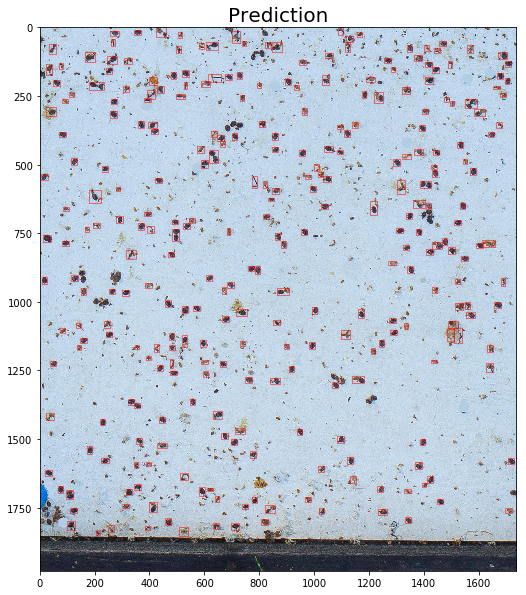

In [69]:
draw_boxes(img_1, img_1_pred)
plt.title('Prediction', fontsize=20)

Text(0.5, 1.0, 'Ground truth')

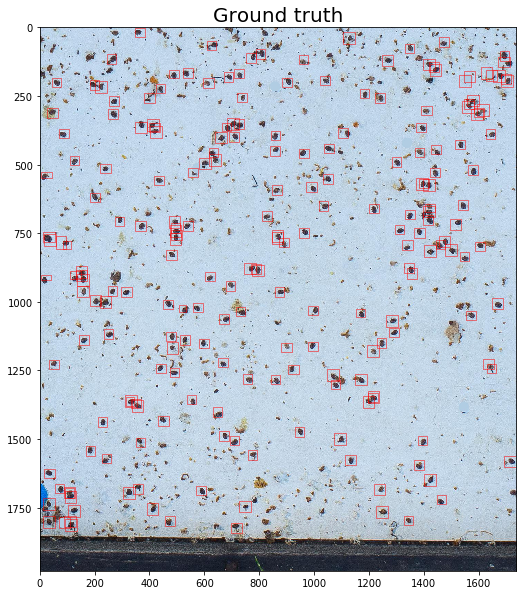

In [71]:
draw_boxes(img_1, img_1_truth)
plt.title('Ground truth', fontsize=20)

In [72]:
precision, recall, f1 = compute_statistics(img_1_truth, img_1_pred)
print('Precision: {:0.2f} \nRecall: {:0.2f} \nF1: {:0.2f}'.format(precision, recall, f1))

Precision: 0.65 
Recall: 0.92 
F1: 0.76


#### Example where it does not work well - img_2

In [74]:
img_2 = skimage.io.imread(test_path + '/599c489b579e52a0e6c05e5c_32.00px_1.jpg')
annotations_2 = parse_file(test_annotations_path + '/599c489b579e52a0e6c05e5c_32.00px_1.xml')

# Pred
img_2_pred = detect_by_segmentation(img_2)

# Truth
img_2_truth = []
for anno in annotations_2:
    y_min = anno['bbox'][0]
    x_min = anno['bbox'][1]
    h = anno['bbox'][2]
    w = anno['bbox'][3]

    x_center = (x_min+h/2) 
    y_center = (y_min+w/2)
        
    img_2_truth.append([x_center, y_center, h, w])

Text(0.5, 1.0, 'Prediction')

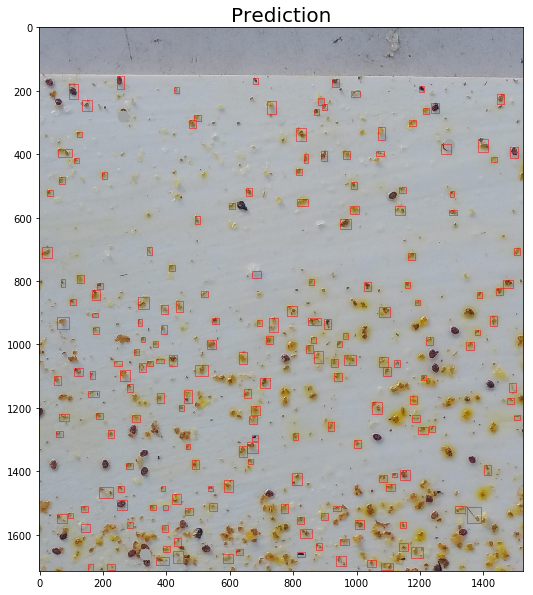

In [75]:
draw_boxes(img_2, img_2_pred)
plt.title('Prediction', fontsize=20)

Text(0.5, 1.0, 'Ground truth')

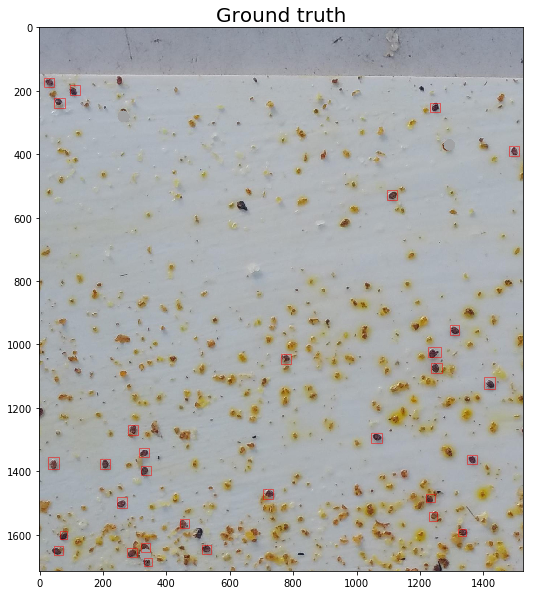

In [76]:
draw_boxes(img_2, img_2_truth)
plt.title('Ground truth', fontsize=20)

In [77]:
precision, recall, f1 = compute_statistics(img_2_truth, img_2_pred)
print('Precision: {:0.2f} \nRecall: {:0.2f} \nF1: {:0.2f}'.format(precision, recall, f1))

Precision: 0.02 
Recall: 0.13 
F1: 0.04


#### Further investigations - Set threshold manually

Text(0.5, 1.0, 'Img 2 thresholded')

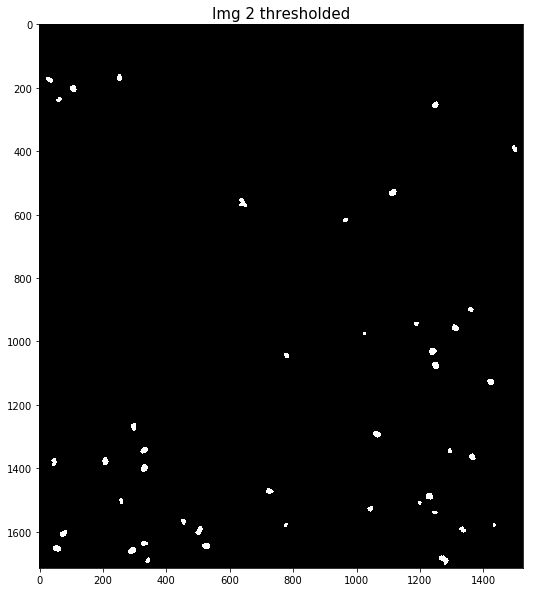

In [86]:
img_2_gs = skimage.color.rgb2grey(img_2)

# Set threshold manually
thresh = 0.4
img_2_processed = binary_opening(img_2_gs < thresh, disk(5)) #closing(image < thresh)
img_2_processed = clear_border(img_2_processed)
plt.subplots(figsize=(10,10))
plt.imshow(img_2_processed, cmap='gray')
plt.title('Img 2 thresholded', fontsize=15)

Text(0.5, 1.0, 'Prediction using manually set threshold')

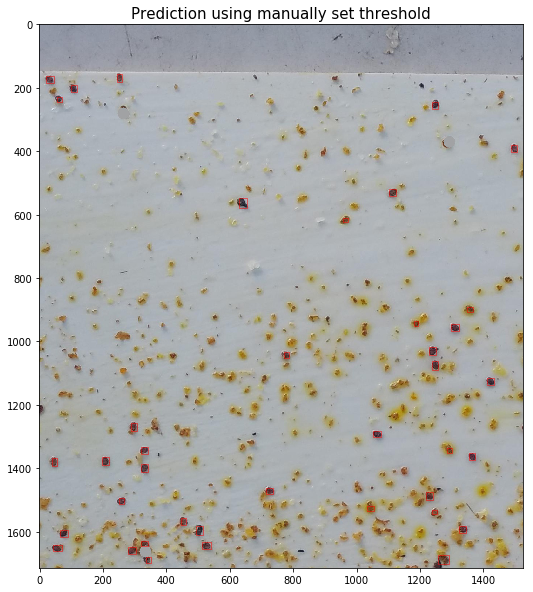

In [89]:
label_img_2 = label(img_2_processed)

img_2_predictions = []
for region in regionprops(label_img_2):
    if (region.area >= 150 and region.area <= 750): 
        x_center, y_center = region.centroid
        minr, minc, maxr, maxc = region.bbox
        img_2_predictions.append([x_center, y_center, maxr-minr, maxc-minc])

draw_boxes(img_2, img_2_predictions)
plt.title('Prediction using manually set threshold', fontsize=15)

In [88]:
precision, recall, f1 = compute_statistics(img_2_truth, varroa_pred)
print('Precision: {:0.2f} \nRecall: {:0.2f} \nF1: {:0.2f}'.format(precision, recall, f1))

Precision: 0.77 
Recall: 1.00 
F1: 0.87


As shown with the latter example (img_2), the *detected_by_segmentation* cannot properly set the threshold. Hence the varroas cannot be detected accurately, resulting in a low precision.

By setting the threshold manually (here $T = 0.4$), better results are achieved. It shows that the provided method cannot be applied to all kind of images. Generalization is not satisfying.

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code